# **Speed Recognition and Measurement Subproject**  

This program utilizes YOLO to recognize and measure speed. It can directly read video files and ultimately output the actual motion speed in both the **x** and **y** directions, as well as the resultant speed.  

The **scaling factor** between video pixels and actual distance needs to be manually calculated. This is done by measuring the pixel distance between marked points in the video and combining it with the actual distance measured during the experiment.

## Extracting Video Frames for Speed Analysis

In [6]:
import cv2
import os

def video_to_frames(video_path, frames_dir):
    # Ensure the directory for saving frames exists
    if not os.path.exists(frames_dir):
        os.makedirs(frames_dir)

    # Load the video
    cap = cv2.VideoCapture(video_path)

    frame_count = 0
    while True:
        # Read the video frame by frame
        success, frame = cap.read()
        if not success:
            break  # Exit the loop if there are no more frames

        # Construct the file path for saving the frame
        frame_path = os.path.join(frames_dir, f"{frame_count:04d}.jpg")
        # Save the frame as an image
        cv2.imwrite(frame_path, frame)
        frame_count += 1

    # Release the video resource
    cap.release()
    print(f"Total frames extracted: {frame_count}")

# Camera 3 video extraction
video_path_3 = 'Video_part1.mov'  # Path to the video file
frames_dir_3 = 'Video_part'  # Directory to save extracted frames
video_to_frames(video_path_3, frames_dir_3)

Total frames extracted: 6221


##  YOLOv7 IMU Detection on Video Frames
This program runs YOLOv7 to detect objects in extracted video frames, saving the detection results as text files.

In [7]:
import subprocess
from pathlib import Path

def run_detection():
    # Set paths and parameters
    detect_script_path = "yolov7/detect.py"
    weights_path = "best.pt"  # Model weights file
    source_folder = "Video_part1"  # Folder containing input images
    project_path = "detections"  # Directory to save detection results
    name = "my_detections"  # Subfolder for this detection run

    # Create command to execute YOLOv7 detection
    command = [
        ".venv/Scripts/python", "yolov7/detect.py",
        "--weights", "best.pt",  # Path to model weights
        "--source", "Video_part",  # Path to input images
        "--img-size", "1280",  # Image size for inference
        "--conf-thres", "0.07",  # Confidence threshold for detections
        "--iou-thres", "0.05",  # IoU threshold for non-max suppression
        "--device", "0",  # GPU device ID (0 for first GPU)
        "--project", "detections",  # Output directory for results
        "--name", "my_detections",  # Folder name within output directory
        "--save-txt",  # Save detection results as text files
        "--exist-ok"  # Overwrite existing results if necessary
    ]

    # Run the command
    result = subprocess.run(command, text=True, capture_output=True)

    # Print output results and errors
    if result.returncode == 0:
        print("Detection completed successfully.")
        print(result.stdout)
    else:
        print("Error in detection process.")
        print(result.stderr)

if __name__ == "__main__":
    run_detection()


Detection completed successfully.
Namespace(weights=['best.pt'], source='Video_part', img_size=1280, conf_thres=0.07, iou_thres=0.05, device='0', view_img=False, save_txt=True, save_conf=False, nosave=False, classes=None, agnostic_nms=False, augment=False, update=False, project='detections', name='my_detections', exist_ok=True, no_trace=False)
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 IMU_Device, Done. (36.0ms) Inference, (82.6ms) NMS
 The image with the result is saved in: detections\my_detections\0000.jpg
2 IMU_Devices, Done. (39.0ms) Inference, (4.0ms) NMS
 The image with the result is saved in: detections\my_detections\0001.jpg
2 IMU_Devices, Done. (38.2ms) Inference, (4.0ms) NMS
 The image with the result is saved in: detections\my_detections\0002.jpg
2 IMU_Devices, Done. (34.5ms) Inference, (4.0ms) NMS
 The image with the result

## Convert Image Sequence to Video
This program combines images from a specified folder into a video file with a given frame rate.

In [8]:
import cv2
import os

def images_to_video(image_folder, output_video, fps):
    # List of supported image formats
    supported_formats = {".jpg", ".jpeg", ".png"}
    
    # Retrieve all images with supported formats
    images = [img for img in os.listdir(image_folder) if os.path.splitext(img)[1].lower() in supported_formats]
    images.sort()  # Ensure images are sorted by filename

    # Read the first image to get video dimensions
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    # Define video codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use mp4v encoding
    video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

    # Add each image to the video
    for image in images:
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()


images_to_video('detections/my_detections', 'detections/part2.mp4', 60)


## Convert Text Files to CSV for Data Analysis
This program reads numerical data from multiple text files in a specified folder and compiles them into a CSV file.

In [9]:
import os
import pandas as pd

def txt_to_csv(folder_path, output_csv, num_files):
    # Create an empty list to store data
    data = []

    # Iterate through the expected file name sequence
    for i in range(1, num_files + 1):
        filename = f'{i:04d}.txt'
        file_path = os.path.join(folder_path, filename)
        
        # Check if the file exists
        if os.path.exists(file_path):
            # Read the first line of the file
            with open(file_path, 'r', encoding='utf-8') as file:
                first_line = file.readline().strip()  # Read the first line and remove trailing spaces
                print(f'Read from {filename}: {first_line}')  # Debug output
                numbers = [float(num) for num in first_line.split()]
                data.append([i] + numbers)  # Add file name and numerical data to the list
        else:
            # If the file does not exist, add the file name with empty content
            data.append([i, None])

    # Create a DataFrame
    df = pd.DataFrame(data, columns=['order', 'zero', 'x', 'y', 'width', 'height'])

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)

# Specify the folder and output CSV file path
folder_path = 'detections/my_detections/labels'  # Modify to your folder path
output_csv = 'detections/my_detections/labels/output.csv'  # Desired output CSV file
num_files = 6221  # Specify the number of files to check, e.g., from 1.txt to 6221.txt

txt_to_csv(folder_path, output_csv, num_files)


Read from 0001.txt: 0 0.453906 0.368056 0.00572917 0.0101852
Read from 0002.txt: 0 0.454688 0.368287 0.00520833 0.00972222
Read from 0003.txt: 0 0.455078 0.368287 0.00546875 0.0106481
Read from 0004.txt: 0 0.455469 0.368287 0.0046875 0.00972222
Read from 0005.txt: 0 0.45625 0.369213 0.0046875 0.00972222
Read from 0006.txt: 0 0.441016 0.368981 0.00546875 0.0138889
Read from 0007.txt: 0 0.441406 0.368981 0.00572917 0.0138889
Read from 0008.txt: 0 0.441797 0.369213 0.00546875 0.0134259
Read from 0009.txt: 0 0.442187 0.368981 0.00520833 0.0138889
Read from 0010.txt: 0 0.442578 0.368981 0.00546875 0.0138889
Read from 0011.txt: 0 0.457031 0.369907 0.00572917 0.0111111
Read from 0012.txt: 0 0.442578 0.368981 0.00546875 0.0138889
Read from 0013.txt: 0 0.458073 0.36875 0.0046875 0.0106481
Read from 0014.txt: 0 0.442969 0.368981 0.00572917 0.0138889
Read from 0015.txt: 0 0.442969 0.368519 0.00572917 0.0138889
Read from 0016.txt: 0 0.442969 0.368519 0.00572917 0.0138889
Read from 0017.txt: 0 0.44

## Perform Linear Interpolation on CSV Data
This program reads a CSV file, applies linear interpolation to missing numerical values, rounds the results, and saves the processed data to a new CSV file.

In [10]:
import pandas as pd
import numpy as np

# Read the CSV file
df = pd.read_csv('detections/my_detections/labels/output.csv')

# Ensure data is in numerical format
df['zero'] = pd.to_numeric(df['zero'], errors='coerce')
df['x'] = pd.to_numeric(df['x'], errors='coerce')
df['y'] = pd.to_numeric(df['y'], errors='coerce')
df['width'] = pd.to_numeric(df['width'], errors='coerce')
df['height'] = pd.to_numeric(df['height'], errors='coerce')

# Apply linear interpolation for X and Y values
df['zero'] = df['zero'].interpolate(method='linear')
df['x'] = df['x'].interpolate(method='linear')
df['y'] = df['y'].interpolate(method='linear')
df['width'] = df['width'].interpolate(method='linear')
df['height'] = df['height'].interpolate(method='linear')

# Round values to six decimal places
df['x'] = df['x'].round(6)
df['y'] = df['y'].round(6)
df['width'] = df['width'].round(6)
df['height'] = df['height'].round(6)

# Check the interpolated data
print(df[['x', 'y']])

# Save the processed data to a new CSV file
df.to_csv('detections/my_detections/labels/interpolate_coordinate.csv', index=False)


             x         y
0     0.453906  0.368056
1     0.454688  0.368287
2     0.455078  0.368287
3     0.455469  0.368287
4     0.456250  0.369213
...        ...       ...
6216  0.493359  0.381481
6217  0.493359  0.381481
6218  0.493359  0.381481
6219  0.493359  0.381481
6220  0.493359  0.381481

[6221 rows x 2 columns]

## Calculate Video Duration from Frame Count and FPS
This program opens a video file, retrieves its total frame count and frame rate (FPS), and calculates the video's duration in seconds.

In [11]:
import cv2

# Open the video file
video_path = "Video_part1.mov"
cap = cv2.VideoCapture(video_path)

# Check if the video file was successfully opened
if not cap.isOpened():
    print("Unable to open video file")
else:
    # Get the total number of frames in the video
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Get the frame rate (frames per second)
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Calculate the video duration (seconds)
    video_length = frame_count / fps
    print(f"Video duration: {video_length:.2f} seconds")

# Release resources
cap.release()


Video duration: 103.96 seconds


## Apply Butterworth Low-Pass Filter to CSV Data and Plot Results
This program reads x and y coordinate data from a CSV file, applies a Butterworth low-pass filter, and visualizes the original vs. filtered data.

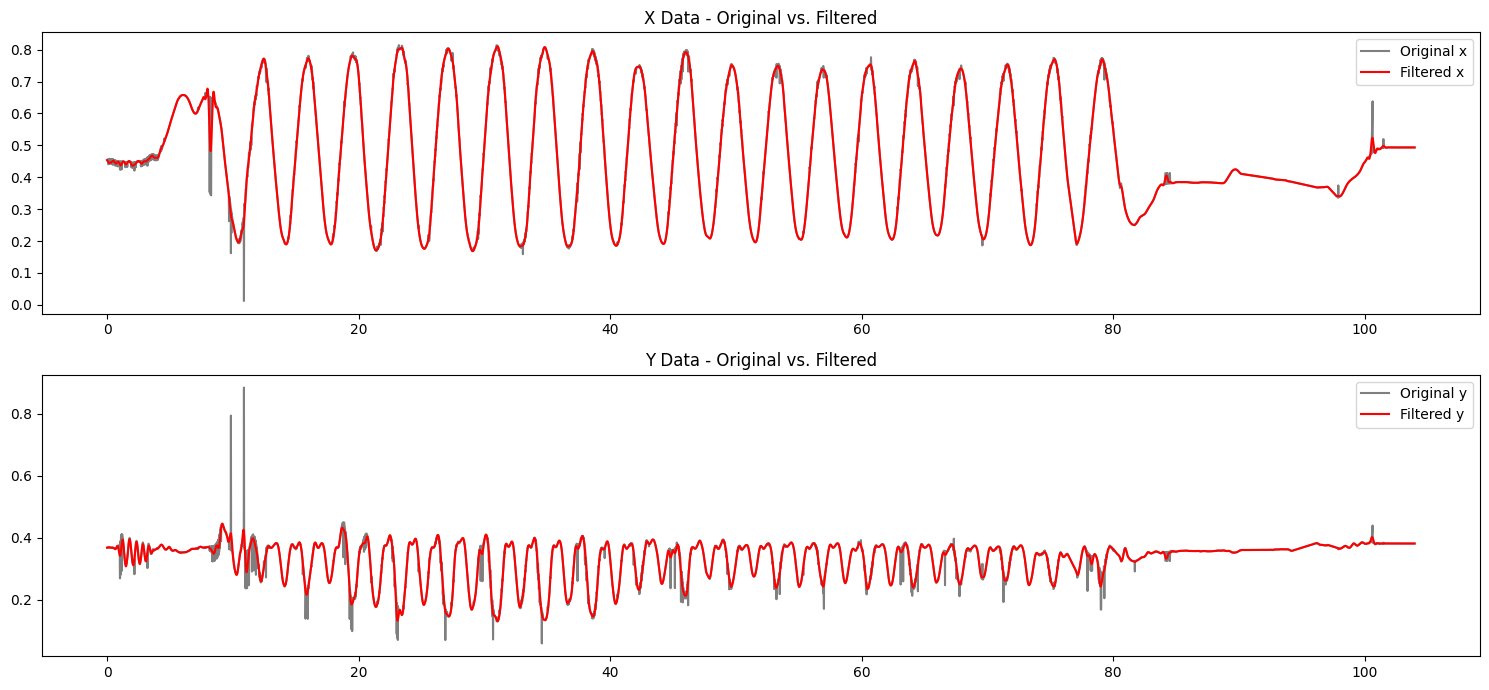

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Define Butterworth low-pass filter function
def butter_lowpass_filter(data, cutoff, fs, order=6):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Read CSV file
input_csv = 'detections/my_detections/labels/interpolate_coordinate.csv'  # Input CSV file path
df = pd.read_csv(input_csv)

# Check if the CSV file contains 'x' and 'y' columns
if 'x' not in df.columns or 'y' not in df.columns:
    raise ValueError("The CSV file must contain 'x' and 'y' columns")

# Extract x and y columns
x = df['x']
y = df['y']

# Set filter parameters
cutoff_freq = 3  # Cutoff frequency (e.g., 3 Hz)
sampling_rate = 60  # Sampling rate (e.g., 60 Hz)
order = 6  # Filter order

# Apply Butterworth low-pass filter to x and y columns
x_filtered = butter_lowpass_filter(x, cutoff_freq, sampling_rate, order)
y_filtered = butter_lowpass_filter(y, cutoff_freq, sampling_rate, order)

# Generate time axis based on the video length
time = np.linspace(0, video_length, len(x_filtered))

# Plot original vs. filtered x and y data
plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(time, x, label='Original x', color='black', alpha=0.5)
plt.plot(time, x_filtered, label='Filtered x', color='red')
plt.title('X Data - Original vs. Filtered')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, y, label='Original y', color='black', alpha=0.5)
plt.plot(time, y_filtered, label='Filtered y', color='red')
plt.title('Y Data - Original vs. Filtered')
plt.legend()

plt.tight_layout()

# Save the plot as an SVG file
plt.savefig("x_y_velocity_part2.svg", format="svg", bbox_inches='tight')
plt.show()
plt.close()


## Calculate and Plot Velocity from Filtered Position Data
This program calculates velocity in the x and y directions, along with the total speed, from filtered coordinate data and plots the x-velocity over time.

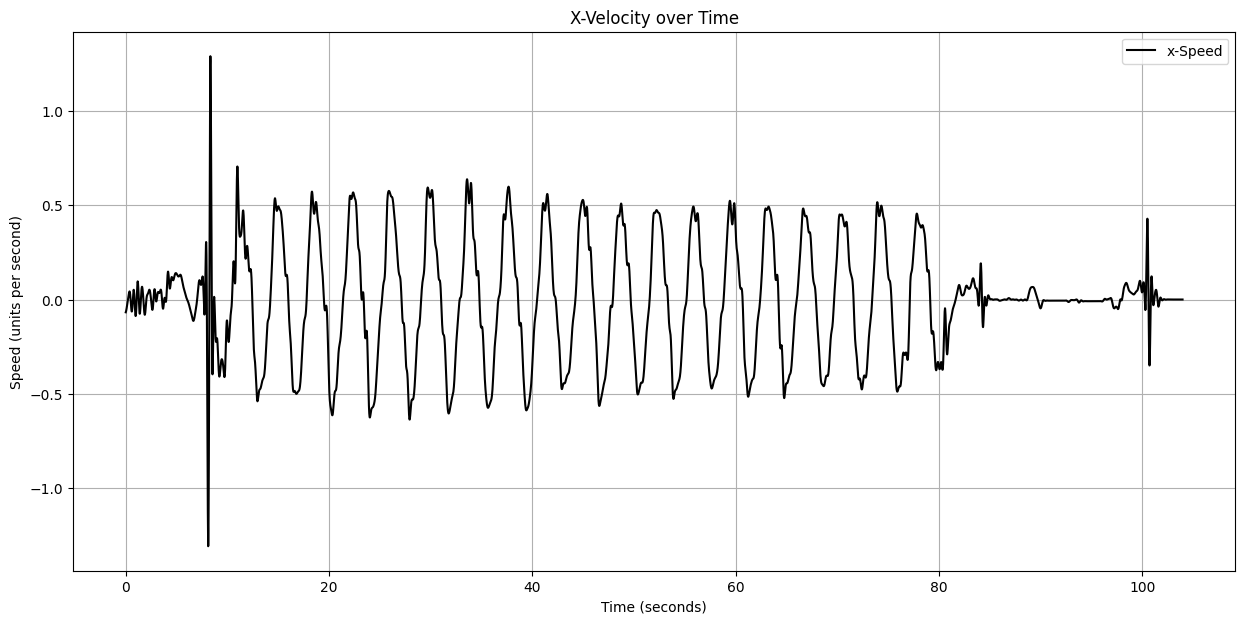

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_velocity(x_filtered, y_filtered, sampling_rate):
    # Compute time interval
    delta_t = 1.0 / sampling_rate

    # Compute velocity in x and y directions
    vx = np.diff(x_filtered) / delta_t
    vy = np.diff(y_filtered) / delta_t

    # Compute total speed (magnitude of velocity)
    speed = np.sqrt(vx**2 + vy**2)

    return vx, vy, speed

# Use previously filtered x and y data
vx, vy, speed = calculate_velocity(x_filtered, y_filtered, sampling_rate)

# Generate time axis (since np.diff reduces the data length by one, adjust the time array accordingly)
time = np.linspace(0, video_length, len(vx))

# Plot x-direction velocity over time
plt.figure(figsize=(15, 7))
plt.plot(time, vx, label='x-Speed', color='black')
plt.title('X-Velocity over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Speed (units per second)')
plt.legend()
plt.grid(True)
plt.show()


## Calculate and Plot Speed from Filtered Position Data
This program computes velocity in the x and y directions, calculates the total speed, and visualizes the speed over time.

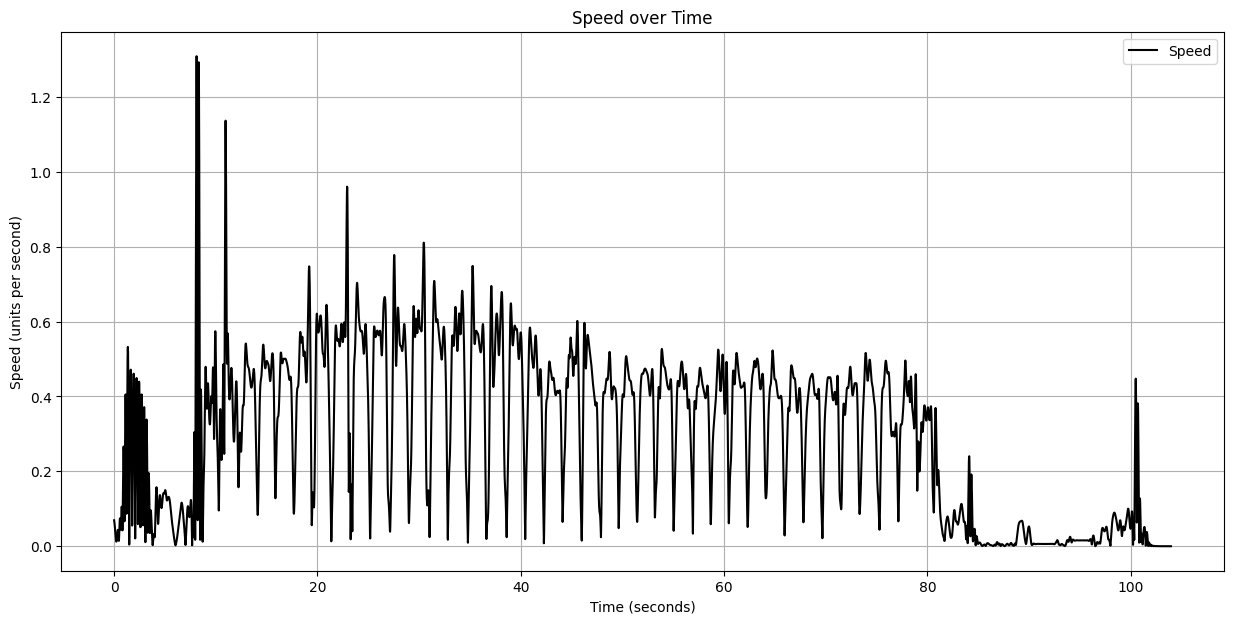

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_velocity(x_filtered, y_filtered, sampling_rate):
    # Compute time interval
    delta_t = 1.0 / sampling_rate

    # Compute velocity in the x and y directions
    vx = np.diff(x_filtered) / delta_t
    vy = np.diff(y_filtered) / delta_t

    # Compute total speed (magnitude of velocity)
    speed = np.sqrt(vx**2 + vy**2)

    return vx, vy, speed

# Use previously filtered x and y data
vx, vy, speed = calculate_velocity(x_filtered, y_filtered, sampling_rate)

# Generate time axis (since np.diff reduces the data length by one, adjust the time array accordingly)
time = np.linspace(0, video_length, len(vx))

# Plot speed over time
plt.figure(figsize=(15, 7))
plt.plot(time, speed, label='Speed', color='black')
plt.title('Speed over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Speed (units per second)')
plt.legend()
plt.grid(True)
plt.show()


## Measure Pixel and Normalized Distance Between Two Points in an Image
This program allows the user to click on two points in an image, calculates the pixel distance and normalized distance between them, and displays the coordinates on the image.

In [25]:
import cv2
import numpy as np
from math import sqrt

# Define a list to store the coordinates of selected points
points = []

# Mouse click event callback function
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        # Get the image dimensions
        img_height, img_width = img.shape[:2]

        # Compute normalized coordinates
        norm_x = x / img_width
        norm_y = y / img_height

        # Display pixel and normalized coordinates
        pixel_text = f"Pixel ({x}, {y})"
        norm_text = f"Norm ({norm_x:.3f}, {norm_y:.3f})"

        cv2.putText(img, pixel_text, (x + 5, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 5)
        cv2.putText(img, norm_text, (x - 50, y + 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 5)

        # Mark the clicked position
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow("Image", img)

        # Add the point to the list
        points.append((x, y))

        # If two points are selected, calculate the distance
        if len(points) == 2:
            x1, y1 = points[0]
            x2, y2 = points[1]

            # Compute the pixel distance between the two points
            distance = sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            print(f"The pixel distance between the two points is: {distance:.2f} pixels")

            # Compute the normalized distance between the two points
            norm_distance = sqrt((norm_x - points[0][0] / img_width) ** 2 + (norm_y - points[0][1] / img_height) ** 2)
            print(f"The normalized distance between the two points is: {norm_distance:.4f}")

# Load the image
img = cv2.imread('detections/my_detections/0000.jpg')

# Display the image
cv2.imshow("Image", img)

# Set mouse callback function
cv2.setMouseCallback("Image", click_event)

# Wait for a key press to close the window
cv2.waitKey(0)
cv2.destroyAllWindows()


From the manually selected window in the previous step, the pixel distance can be measured. Then, based on the actual distance measured in the experiment, the 'scaling_ratio' parameter can be determined.

In [26]:
scaling_ratio= 6.6644

## Apply Butterworth Low-Pass Filter and Plot Scaled Position Data Over Time
This program reads position data from a CSV file, scales it using a predefined ratio, applies a Butterworth low-pass filter, and visualizes the x and y positions over time.


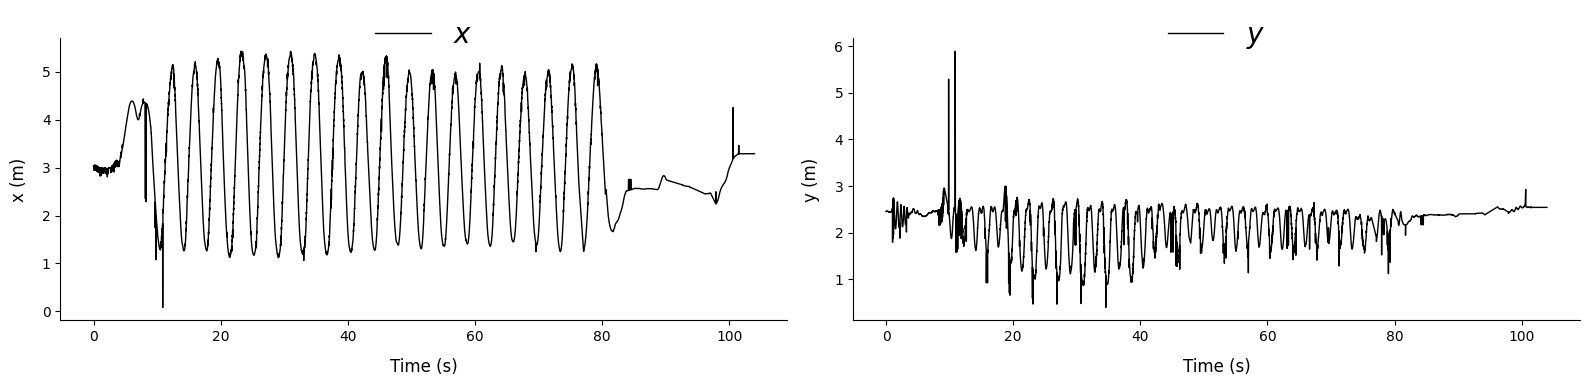

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Define Butterworth low-pass filter function
def butter_lowpass_filter(data, cutoff, fs, order=6):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Read CSV file
input_csv = 'detections/my_detections/labels/interpolate_coordinate.csv'  # Input CSV file path
df = pd.read_csv(input_csv)

# Check if the CSV file contains 'x' and 'y' columns
if 'x' not in df.columns or 'y' not in df.columns:
    raise ValueError("The CSV file must contain 'x' and 'y' columns")

# Scale x and y coordinates using the predefined scaling ratio
x = df['x'] * scaling_ratio
y = df['y'] * scaling_ratio

# Set filter parameters
cutoff_freq = 3  # Cutoff frequency (e.g., 3 Hz)
sampling_rate = 60  # Sampling rate (e.g., 60 Hz)
order = 6  # Filter order

# Apply Butterworth low-pass filter to x and y columns
x_filtered = butter_lowpass_filter(x, cutoff_freq, sampling_rate, order)
y_filtered = butter_lowpass_filter(y, cutoff_freq, sampling_rate, order)

# Generate time axis based on the video length
time = np.linspace(0, video_length, len(x_filtered))

# Plot position data over time
plt.figure(figsize=(16, 4))

# Subplot 1: x-Position Over Time
plt.subplot(1, 2, 1)
plt.plot(time, x, label='$x$', color='black', linewidth=1, linestyle='-')
plt.xlabel('Time (s)', fontsize=12, labelpad=10)
plt.ylabel('x (m)', fontsize=12, labelpad=10)

# Legend style: placed at the top of the plot
plt.legend(
    fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Subplot 2: y-Position Over Time
plt.subplot(1, 2, 2)
plt.plot(time, y, label='$y$', color='black', linewidth=1, linestyle='-')
plt.xlabel('Time (s)', fontsize=12, labelpad=10)
plt.ylabel('y (m)', fontsize=12, labelpad=10)

# Legend style: placed at the top of the plot
plt.legend(
    fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("x and y.svg", format="svg", dpi=600)
plt.show()

# Close the figure after saving
plt.close()


## Plot Scaled X and Y Velocities Over Time
This program generates a time axis, applies a scaling factor to velocity data, and visualizes the x and y velocities over time.

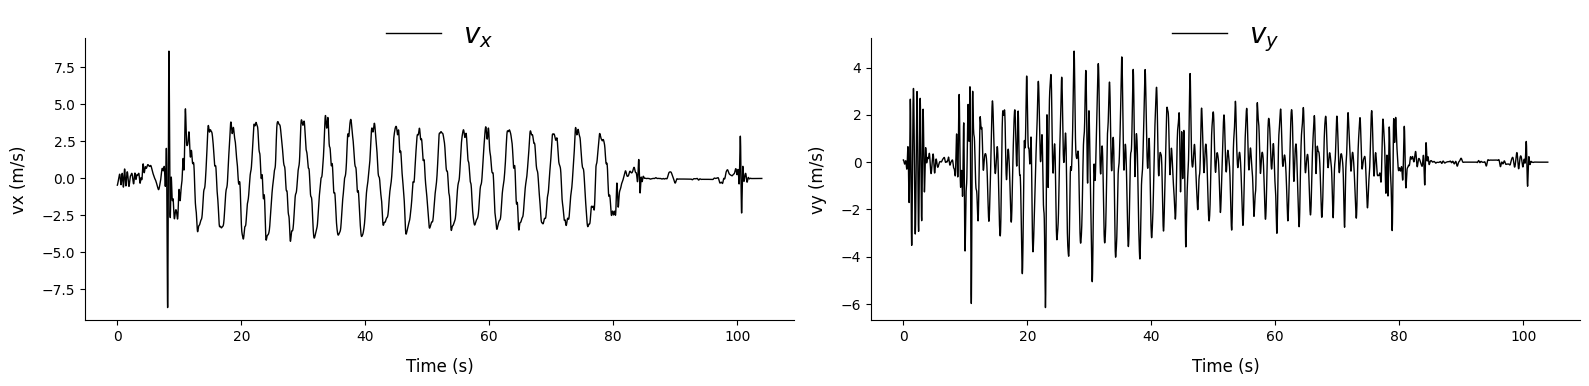

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Generate time axis (considering np.diff reduces data length by one)
time = np.linspace(0, video_length, len(vx))

# Plot velocity graphs
plt.figure(figsize=(16, 4))

# Subplot 1: x-Velocity over Time
plt.subplot(1, 2, 1)
plt.plot(time, vx * scaling_ratio, label='$v_x$', color='black', linewidth=1, linestyle='-')
plt.xlabel('Time (s)', fontsize=12, labelpad=10)
plt.ylabel('vx (m/s)', fontsize=12, labelpad=10)

# Legend style: placed at the top of the plot
plt.legend(
    fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove top and right spines for cleaner visualization
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Subplot 2: y-Velocity over Time
plt.subplot(1, 2, 2)
plt.plot(time, vy * scaling_ratio, label='$v_y$', color='black', linewidth=1, linestyle='-')
plt.xlabel('Time (s)', fontsize=12, labelpad=10)
plt.ylabel('vy (m/s)', fontsize=12, labelpad=10)

# Legend style: placed at the top of the plot
plt.legend(
    fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove top and right spines for cleaner visualization
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("vx and vy.svg", format="svg", dpi=600)
plt.show()

# Close the figure after saving
plt.close()


## Calculate and Plot Speed Over Time from Filtered Position Data
This program calculates velocity components and total speed from filtered position data, visualizes speed over time, and exports the velocity data to a CSV file.

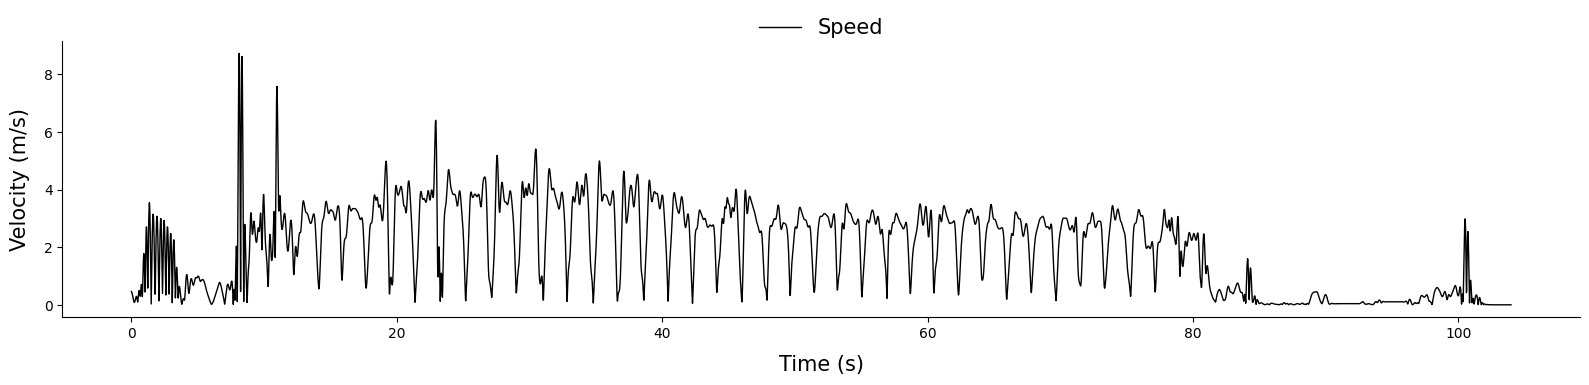

Velocity and speed data have been saved to results/velocity_part1.csv


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_velocity(x_filtered, y_filtered, sampling_rate):
    # Compute time interval
    delta_t = 1.0 / sampling_rate

    # Compute velocity in x and y directions
    vx = np.diff(x_filtered) / delta_t
    vy = np.diff(y_filtered) / delta_t

    # Compute total speed (magnitude of velocity)
    speed = np.sqrt(vx**2 + vy**2)

    return vx, vy, speed

# Use previously filtered x and y data
vx, vy, speed = calculate_velocity(x_filtered, y_filtered, sampling_rate)

# Generate time axis (since np.diff reduces the data length by one)
time = np.linspace(0, video_length, len(vx))

# Plot speed over time
plt.figure(figsize=(16, 4))

# Plot speed curve
plt.plot(
    time, speed, label='Speed', color='black', linewidth=1, linestyle='-'
)

# Add title and axis labels
plt.xlabel('Time (s)', fontsize=15, labelpad=10)
plt.ylabel('Velocity (m/s)', fontsize=15, labelpad=10)

# Legend style: placed at the top of the plot
plt.legend(
    fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove top and right spines for cleaner visualization
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Save the plot as an SVG file
plt.savefig("speed from video.svg", format="svg", dpi=600)

# Show the plot
plt.show()
plt.close()

# Create a DataFrame with velocity data
velocity_data = pd.DataFrame({
    'Time': time,
    'vx': vx,
    'vy': vy,
    'Speed': speed
})

# Export DataFrame to a CSV file
output_csv_path = 'results/velocity_part1.csv'  # Specify the export path
velocity_data.to_csv(output_csv_path, index=False)

print(f"Velocity and speed data have been saved to {output_csv_path}")


## Extract and Analyze Velocity Data in a Specific Time Interval (69-73s) with Advanced Filtering
This program computes velocity components from filtered position data, extracts velocity data for a specified time interval (69-73 seconds), visualizes the speed over this range, and exports the data to a CSV file for further analysis.

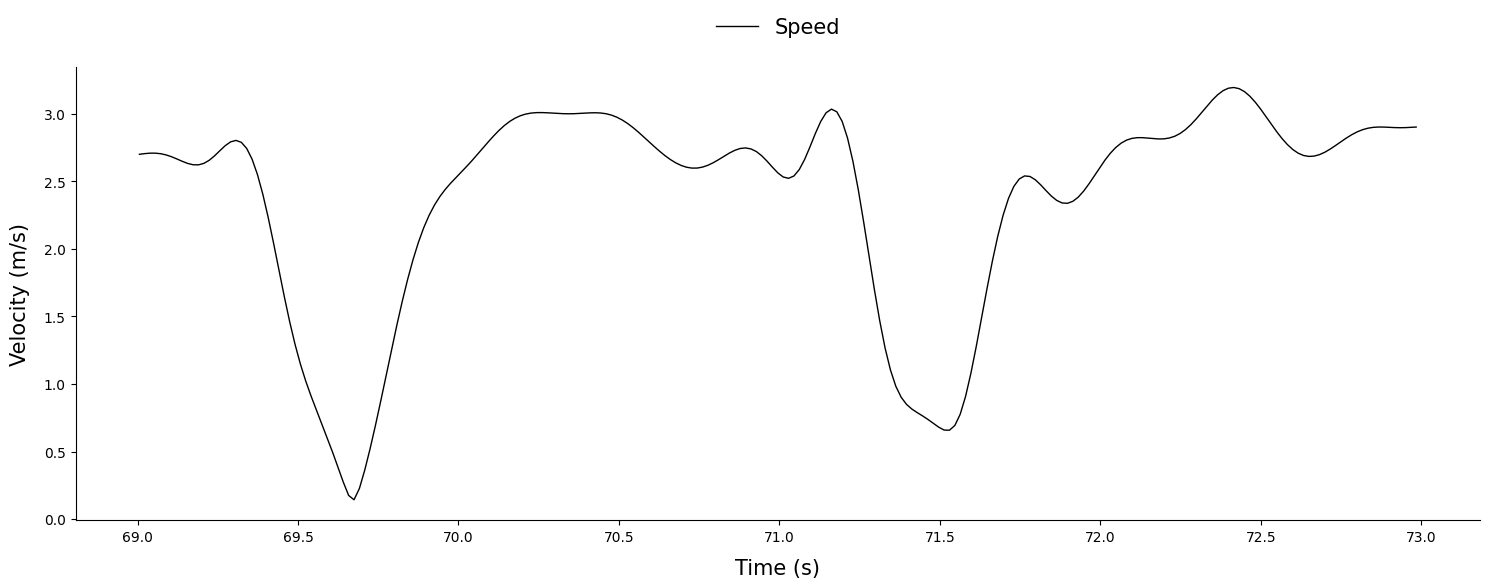

Velocity and speed data (69-73s) have been saved to ./velocity_data_69_to_73.csv


In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def calculate_velocity(x_filtered, y_filtered, sampling_rate):
    # Compute time interval
    delta_t = 1.0 / sampling_rate

    # Compute velocity in the x and y directions
    vx = np.diff(x_filtered) / delta_t
    vy = np.diff(y_filtered) / delta_t

    # Compute total speed (magnitude of velocity)
    speed = np.sqrt(vx**2 + vy**2)

    return vx, vy, speed

# Assuming x_filtered, y_filtered, sampling_rate, and video_length are predefined
vx, vy, speed = calculate_velocity(x_filtered, y_filtered, sampling_rate)

# Generate time axis (since np.diff reduces the data length by one)
time = np.linspace(0, video_length, len(vx))

# Extract data for the 69 to 73-second interval
mask = (time >= 69) & (time <= 73)
time_zoomed = time[mask]
vx_zoomed = vx[mask]
vy_zoomed = vy[mask]
speed_zoomed = speed[mask]

# Plot speed over the selected time interval
plt.figure(figsize=(15, 6))

# Plot speed curve
plt.plot(
    time_zoomed, speed_zoomed, label='Speed', color='black', linewidth=1, linestyle='-'
)

# Add title and axis labels
plt.xlabel('Time (s)', fontsize=15, labelpad=10)
plt.ylabel('Velocity (m/s)', fontsize=15, labelpad=10)

# Legend style: placed at the top of the plot
plt.legend(
    fontsize=15, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2, frameon=False
)

# Remove top and right spines for a cleaner visualization
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Save the plot as an SVG file
plt.savefig("speed_from_video_69_to_73.svg", format="svg", dpi=600)
plt.close()

# Create a DataFrame to store the extracted data
velocity_data_zoomed = pd.DataFrame({
    'Time': time_zoomed,
    'vx': vx_zoomed,
    'vy': vy_zoomed,
    'Speed': speed_zoomed
})

# Export the extracted velocity data to a CSV file
output_csv_path = './velocity_data_69_to_73.csv'  # Specify the export path
velocity_data_zoomed.to_csv(output_csv_path, index=False)

print(f"Velocity and speed data (69-73s) have been saved to {output_csv_path}")


## Overlay Displacement and Velocity Data on Video Frames
This program processes a video frame by frame, overlays displacement, velocity, and speed graphs on each frame, and saves the annotated video.

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from tqdm import tqdm
import pandas as pd

# Video path
video_path = "output_video_30.mp4"
output_path = "output_full_video_with_data.mp4"

# Open the video file
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Unable to open video file")

# Get video parameters
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Create a video writer object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width * 2, frame_height * 2))

# Assume x_filtered and y_filtered data already exist
video_length = frame_count / fps
time = np.linspace(0, video_length, len(x_filtered))

# Set up the matplotlib canvas, with a larger size for clearer content
fig, ax = plt.subplots(2, 2, figsize=(12, 10))  # Larger size for better clarity
canvas = FigureCanvas(fig)
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Increase spacing between subplots

# Iterate through all frames of the video
for frame_idx in tqdm(range(frame_count), desc="Processing all frames"):
    ret, frame = cap.read()
    if not ret:
        break

    # Convert video frame from BGR to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Current time in the video
    current_time = frame_idx / fps
    time_indices = time <= current_time
    
    # Clear previous frame's data
    for row in ax:
        for a in row:
            a.clear()

    # Display the video frame on the canvas
    ax[0, 0].imshow(frame_rgb)
    ax[0, 0].axis('off')
    ax[0, 0].set_title("Original Video")

    # Plot displacement graph
    if time_indices.any():
        ax[0, 1].plot(time[time_indices], x_filtered[time_indices], color='black', label='Filtered x')
        ax[0, 1].plot(time[time_indices], y_filtered[time_indices], color='red', label='Filtered y')
    ax[0, 1].set_title("Displacement over Time")
    ax[0, 1].set_xlabel("Time (s)")
    ax[0, 1].set_ylabel("Displacement (m)")
    ax[0, 1].legend()
    ax[0, 1].grid(True)
    
    # Plot x and y velocity graph
    if frame_idx > 0 and frame_idx < len(vx):
        ax[1, 0].plot(time[:frame_idx], vx[:frame_idx], color='black', label='x-Speed')
        ax[1, 0].plot(time[:frame_idx], vy[:frame_idx], color='red', label='y-Speed')
    ax[1, 0].set_title("Velocity over Time")
    ax[1, 0].set_xlabel("Time (s)")
    ax[1, 0].set_ylabel("Velocity (m/s)")
    ax[1, 0].legend()
    ax[1, 0].grid(True)
    
    # Plot total speed graph
    if frame_idx > 0 and frame_idx < len(speed):
        ax[1, 1].plot(time[:frame_idx], speed[:frame_idx], color='black', label='Speed')
    ax[1, 1].set_title("Speed over Time")
    ax[1, 1].set_xlabel("Time (s)")
    ax[1, 1].set_ylabel("Speed (m/s)")
    ax[1, 1].legend()
    ax[1, 1].grid(True)

    # Render the canvas and resize it to target dimensions
    canvas.draw()
    width, height = fig.get_size_inches() * fig.get_dpi()
    plot_image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(height), int(width), 3)
    resized_plot_image = cv2.resize(plot_image, (frame_width * 2, frame_height * 2))

    # Combine video frame and plots, ensuring the top-left is the video frame, and other areas display plots
    combined_frame = np.zeros((frame_height * 2, frame_width * 2, 3), dtype=np.uint8)
    combined_frame[:frame_height, :frame_width] = frame_rgb  # Top-left: video frame
    combined_frame[:frame_height, frame_width:] = resized_plot_image[:frame_height, frame_width:]  # Top-right: plot
    combined_frame[frame_height:, :frame_width] = resized_plot_image[frame_height:, :frame_width]  # Bottom-left: plot
    combined_frame[frame_height:, frame_width:] = resized_plot_image[frame_height:, frame_width:]  # Bottom-right: plot

    # Convert back to BGR for writing to video file
    out.write(cv2.cvtColor(combined_frame, cv2.COLOR_RGB2BGR))

# Release resources
cap.release()
out.release()
plt.close()

print(f"The complete video has been saved to {output_path}")


Unable to open video file


ZeroDivisionError: float division by zero